####### np.unique(image) ####### [0 1 2]
####### cls_num_list ####### [1, 2]
############ cls_num #############: 1
连通区域的个数(包含背景)为: 2
连通区域的标签为: (1512, 2688) [0 1]
mask的个数(含有少量孤立点)为: 1
np.unique(single_mask): [0 1]
single_mask_new.shape: (1512, 2688) [0 1]


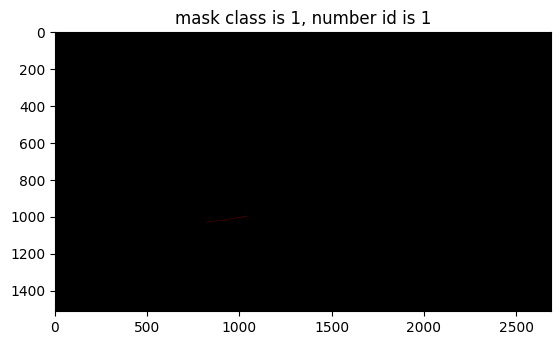

(1512, 2688)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
########### skeleton.shape ########### (1512, 2688) [0 1] uint8
centers.shape (226, 2)
len(contours) 1
bpoints.shape (543, 2)
the 2-th was wrong
the 3-th was wrong
the 4-th was wrong
the 5-th was wrong
the 6-th was wrong
the 7-th was wrong
the 8-th was wrong
the 9-th was wrong
the 10-th was wrong
the 11-th was wrong
the 13-th was wrong
the 19-th was wrong
the 28-th was wrong
the 29-th was wrong
the 62-th was wrong
the 63-th was wrong
the 64-th was wrong
the 65-th was wrong
the 66-th was wrong
the 67-th was wrong
the 68-th was wrong
the 69-th was wrong
the 70-th was wrong
the 71-th was wrong
the 72-th was wrong
the 73-th was wrong
the 74-th was wrong
the 75-th was wrong
the 78-th was wrong
the 79-th was wrong
the 84-th was wrong
the 86-th was wrong
the 87-th was wrong
the 88-th was wrong
the 89-th was wrong
the 90-th was wrong
the 91-th was wrong
the 92-th

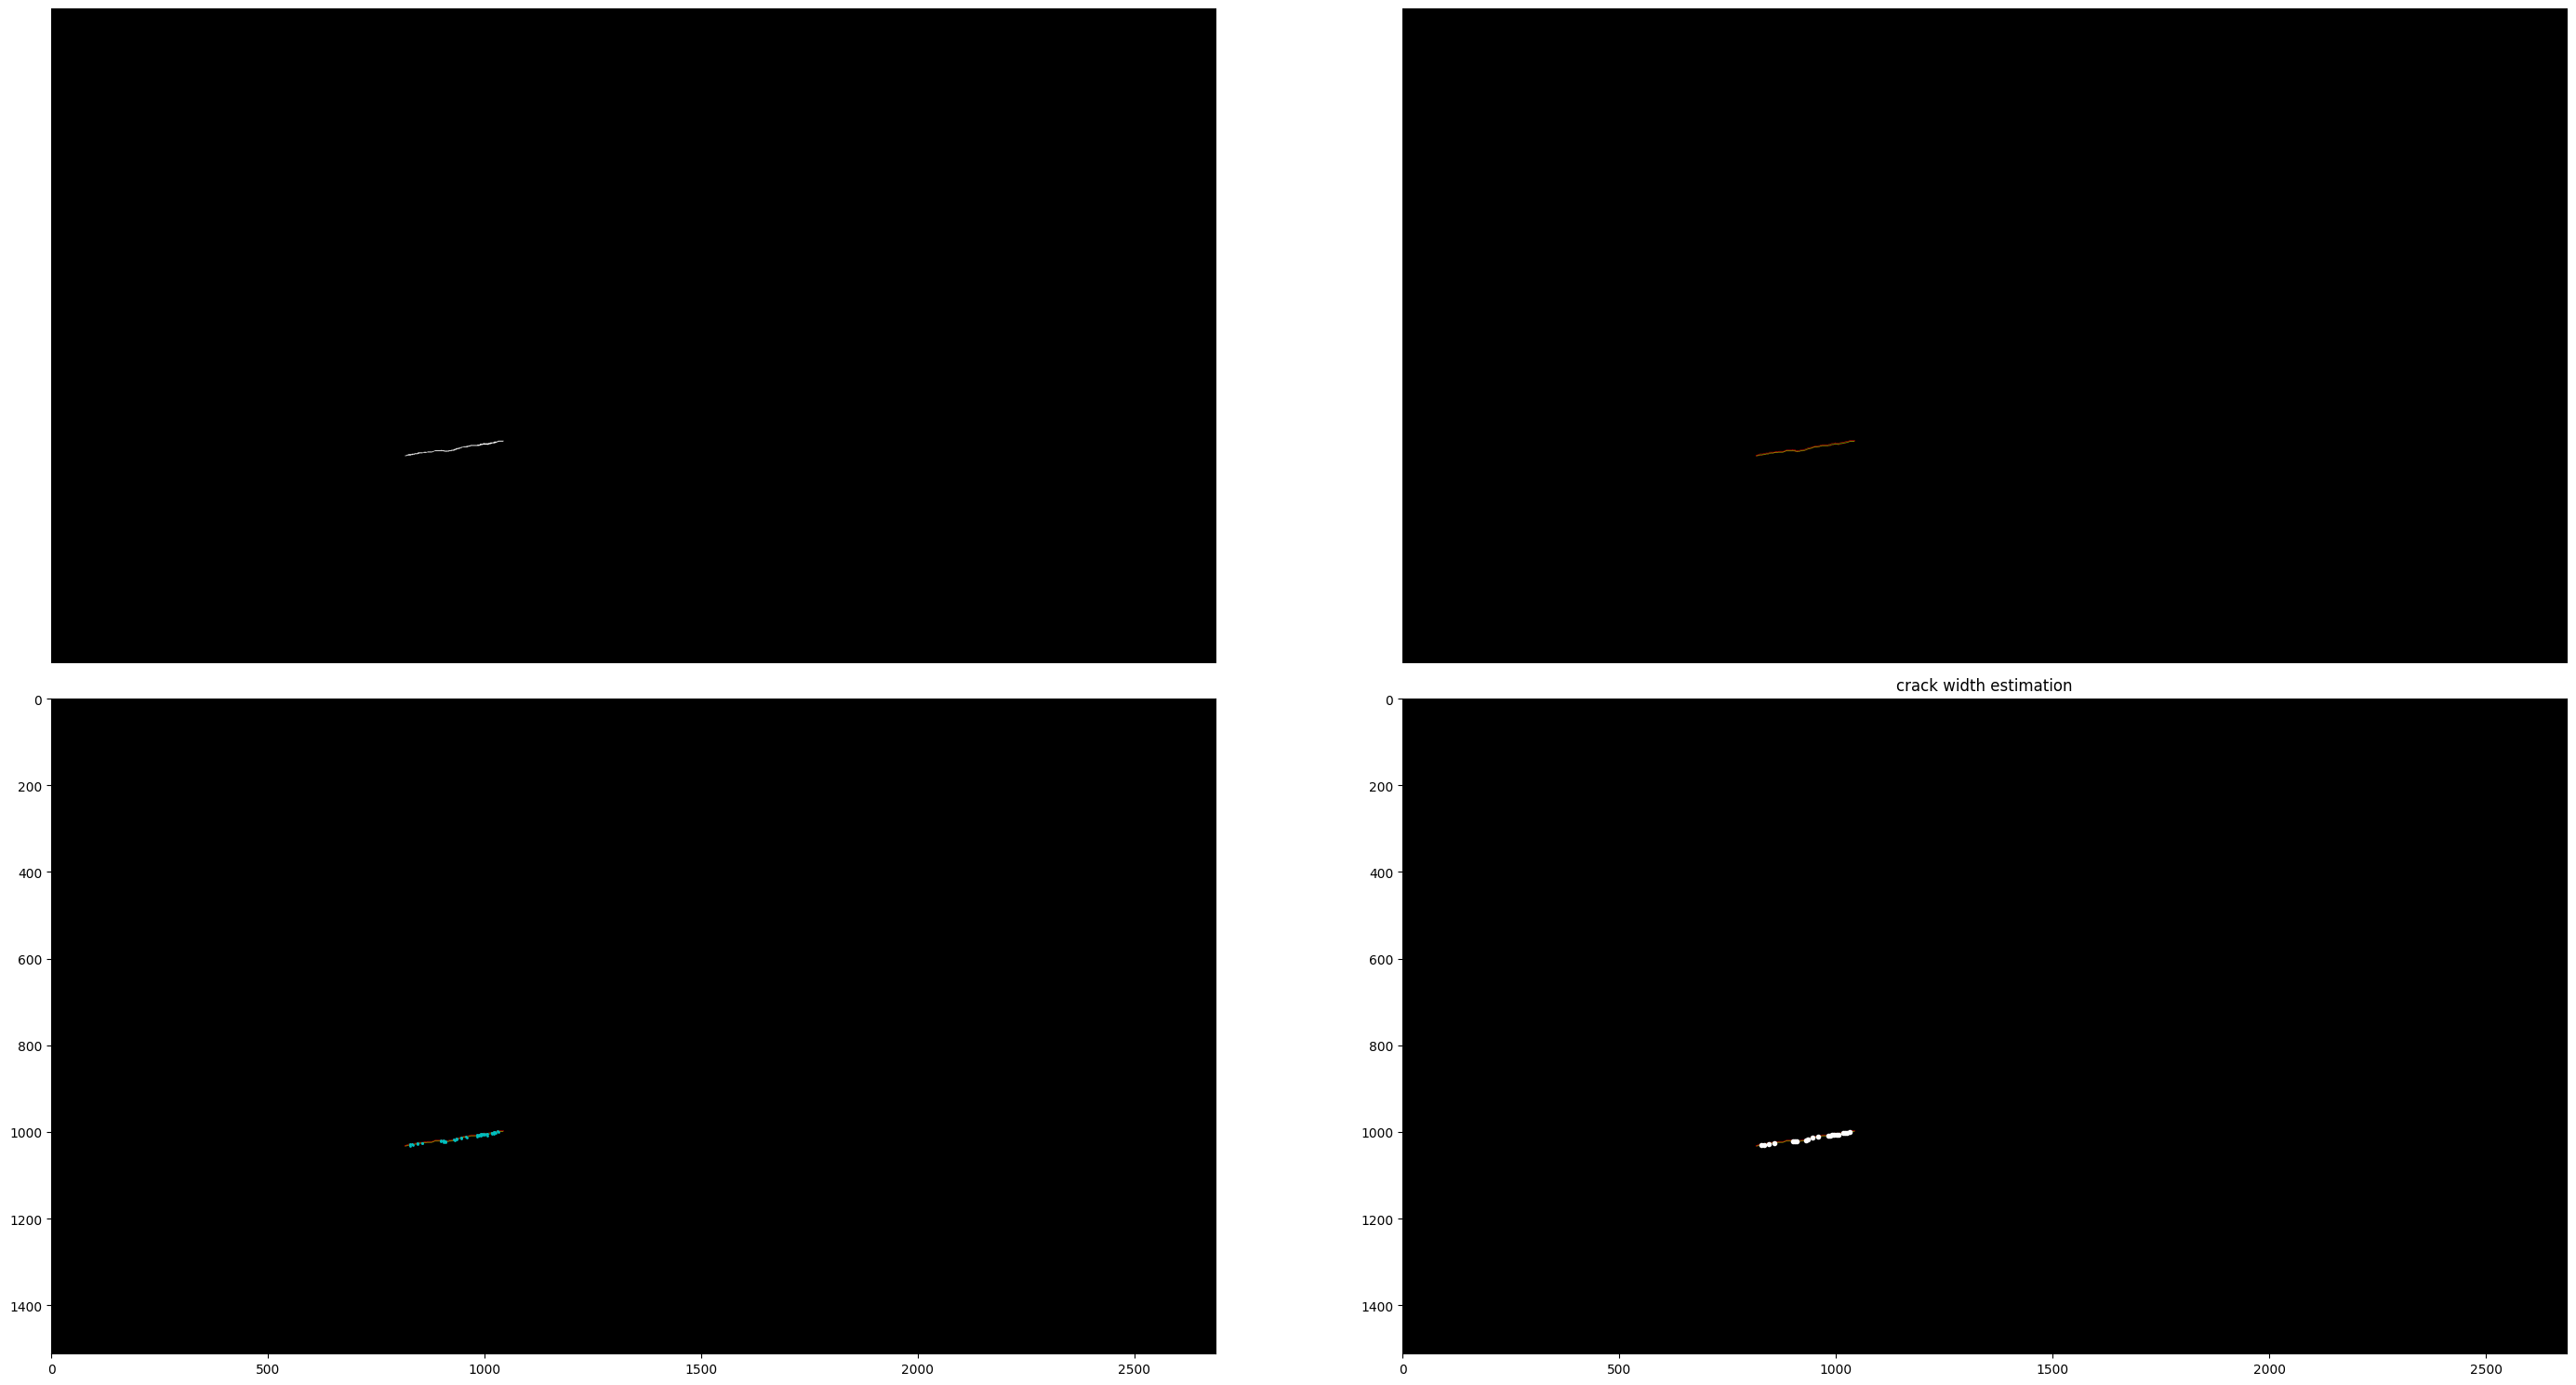

############ cls_num #############: 2
连通区域的个数(包含背景)为: 3
连通区域的标签为: (1512, 2688) [0 1 2]
mask的个数(含有少量孤立点)为: 2
np.unique(single_mask): [0 1]
single_mask_new.shape: (1512, 2688) [0 1]


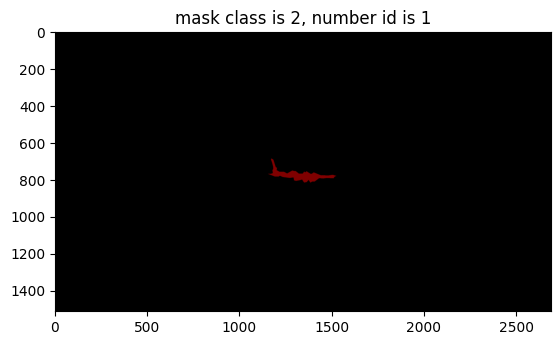

(1512, 2688)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
########### skeleton.shape ########### (1512, 2688) [0 1] uint8
centers.shape (445, 2)
len(contours) 1
bpoints.shape (1195, 2)
the 62-th was wrong
the 63-th was wrong
the 64-th was wrong
the 116-th was wrong
the 148-th was wrong
the 149-th was wrong
the 232-th was wrong
the 233-th was wrong
the 242-th was wrong
interps.shape, widths.shape (436, 4) (436, 3)
interps_center.shape (436, 2)
########### interps_show.shape ########### (88, 4)
widths_show.shape (88, 3)
interps_center_show.shape (88, 2)


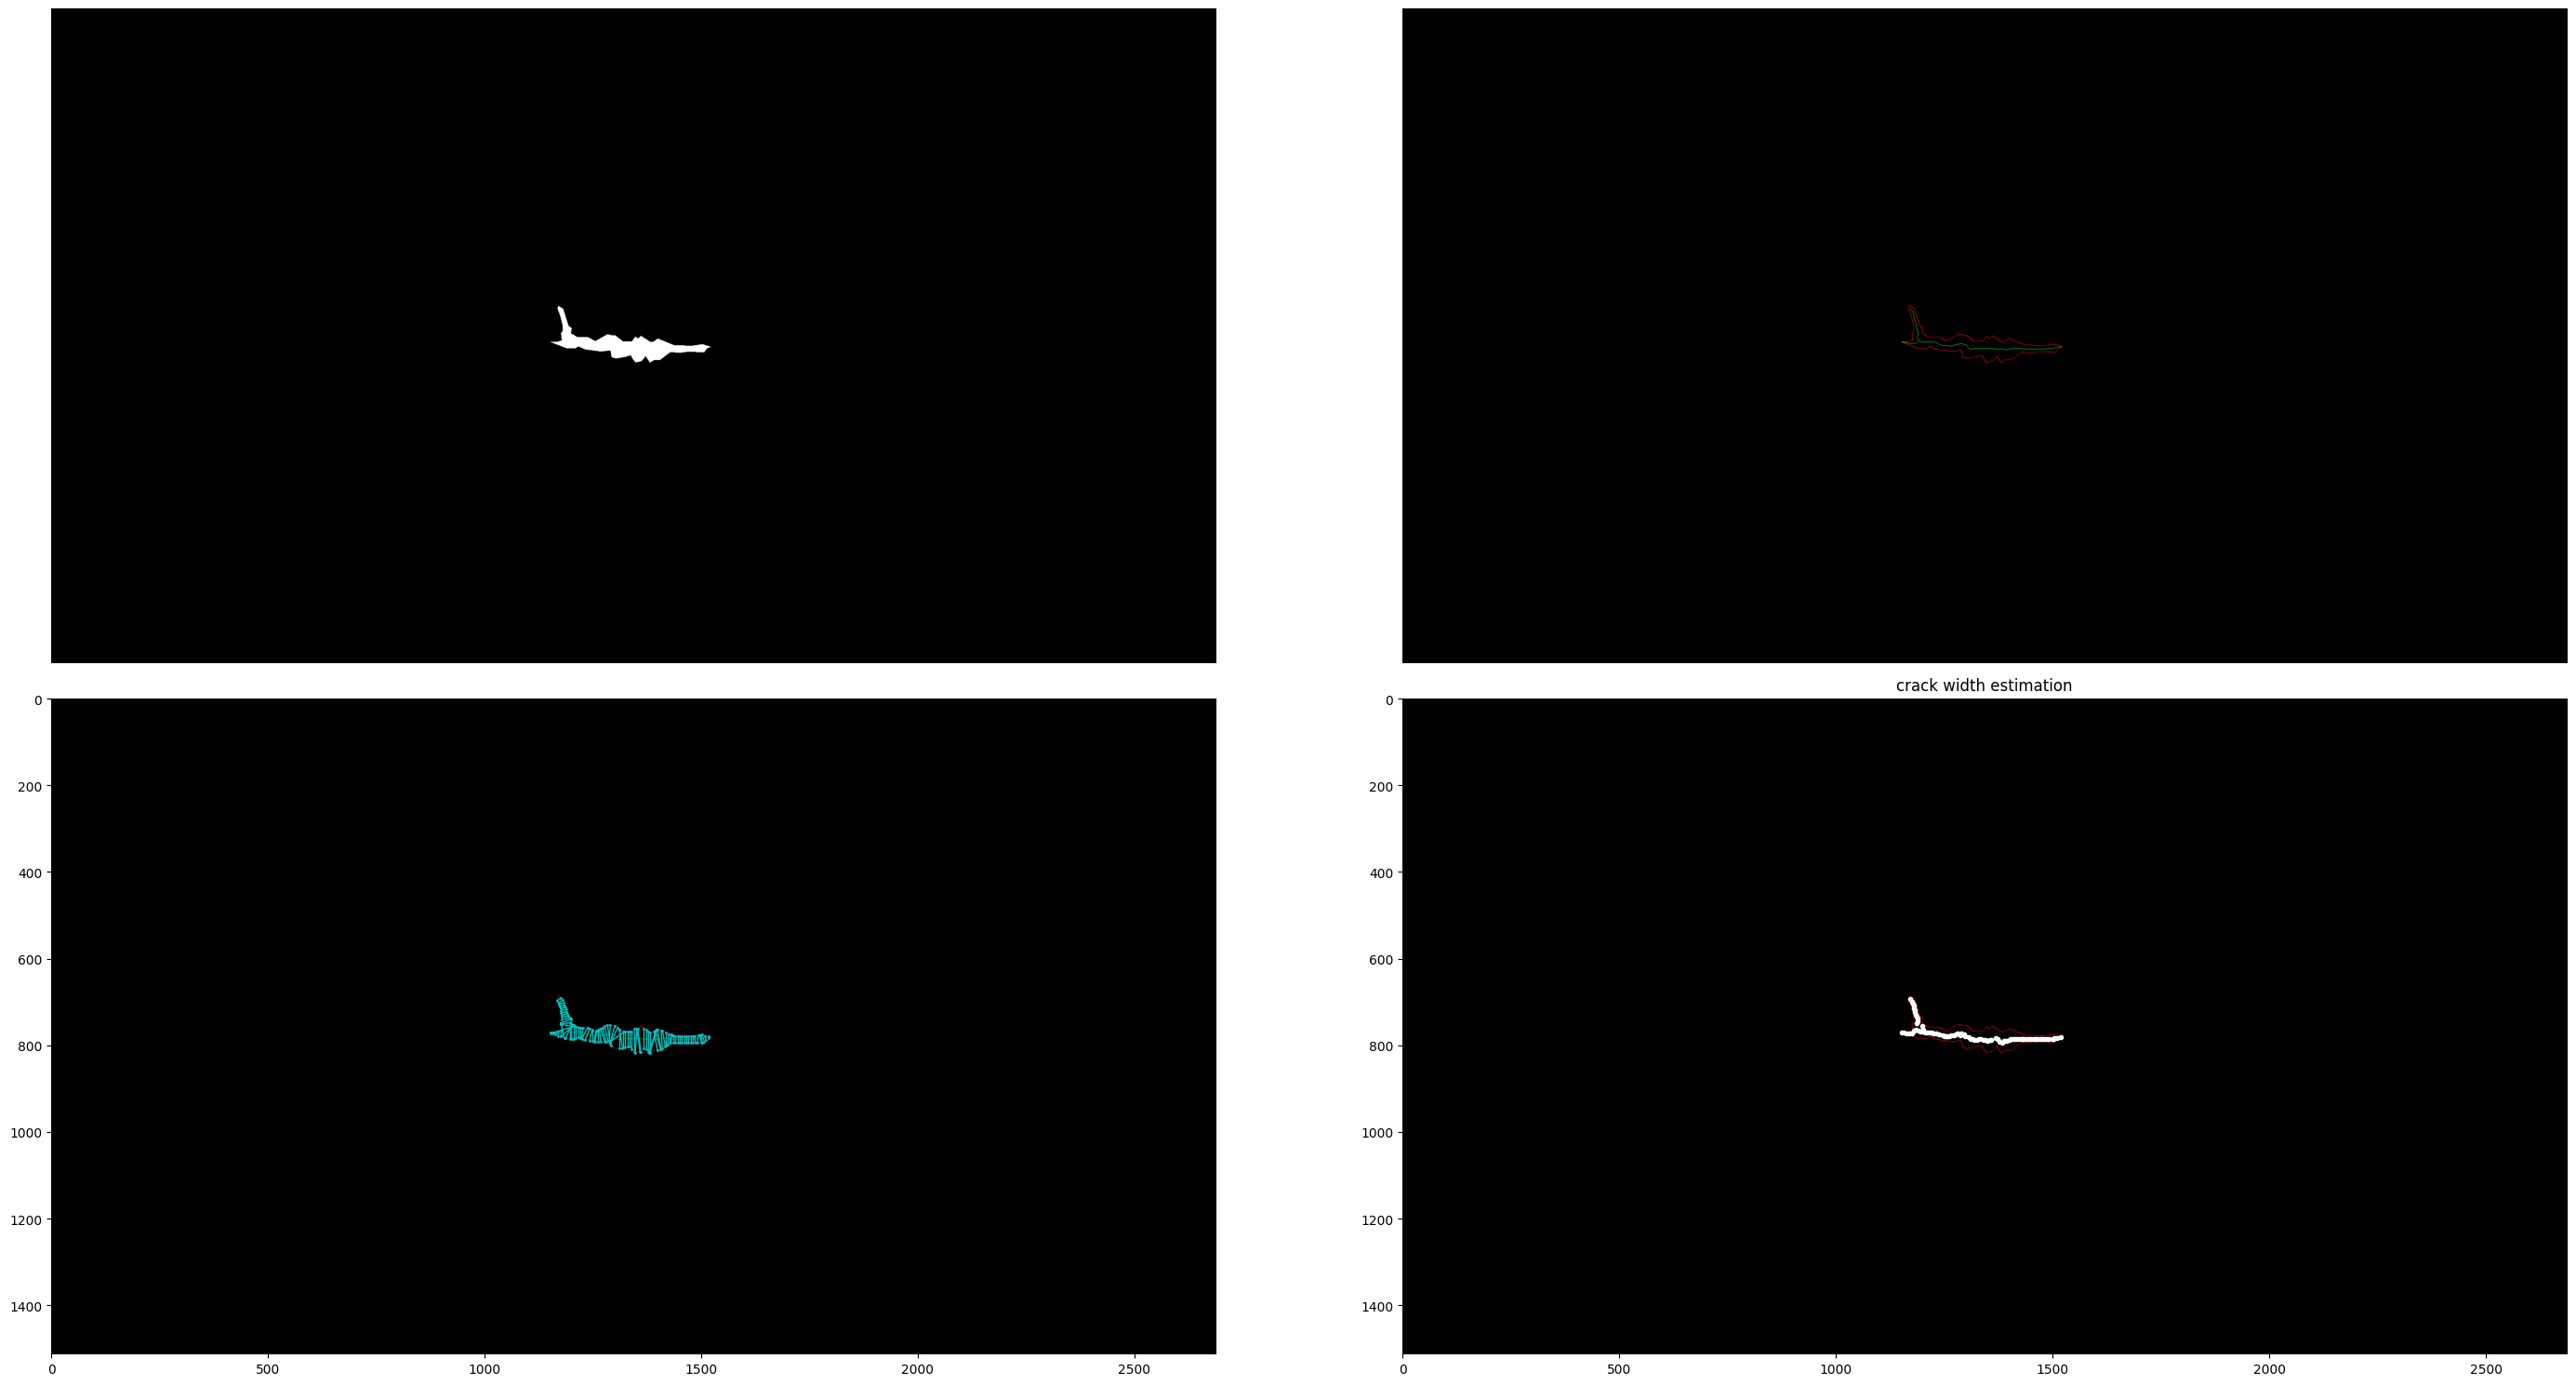

np.unique(single_mask): [0 2]


In [14]:
import numpy as np
from skimage import io
from skimage.morphology import medial_axis, skeletonize
from skimage import measure
from skimage import data
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from PIL import Image

from skimage.measure import label, regionprops
from skimage.morphology import closing, dilation, disk
from skimage.filters import median
from skimage.morphology import binary_opening, disk
import imgviz

def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap, type(colormap), colormap.flatten(), colormap.shape)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil  

def show_2dpoints(pointcluster,s=None,quivers=None,qscale=1):
    # pointcluster should be a list of numpy ndarray
    # This functions would show a list of pint cloud in different colors
    n = len(pointcluster)
    nmax = n
    if quivers is not None:
        nq = len(quivers)
        nmax = max(n,nq)
    
    colors = ['r','g','b','c','m','y','k','tomato','gold']
    if nmax < 10:
        colors = np.array(colors[0:nmax])
    else: 
        colors = np.random.rand(nmax,3)

    fig = plt.figure(num=1)
    ax = fig.add_subplot(1,1,1)

    if s is None:
        s = np.ones(n)*2

    for i in range(n):
        ax.scatter(pointcluster[i][:,0],pointcluster[i][:,1],s=s[i],c=[colors[i]],alpha=0.6)

    if quivers is not None:
        for i in range(nq):
            ax.quiver(quivers[i][:,0],quivers[i][:,1],quivers[i][:,2],quivers[i][:,3],color=[colors[i]],scale=qscale)

    plt.show()


def SVD(points):
    # 二维，三维均适用
    # 二维直线，三维平面
    pts = points.copy()
    # 奇异值分解
    c = np.mean(pts, axis=0)
    A = pts - c # shift the points
    A = A.T #3*n
    u, s, vh = np.linalg.svd(A, full_matrices=False, compute_uv=True) # A=u*s*vh
    normal = u[:,-1]

    # 法向量归一化
    nlen = np.sqrt(np.dot(normal,normal))
    normal = normal / nlen
    # normal 是主方向的方向向量 与PCA最小特征值对应的特征向量是垂直关系
    # u 每一列是一个方向
    # s 是对应的特征值
    # c >>> 点的中心
    # normal >>> 拟合的方向向量
    return u,s,c,normal


def calcu_dis_from_ctrlpts(ctrlpts):
    if ctrlpts.shape[1]==4:
        return np.sqrt(np.sum((ctrlpts[:,0:2]-ctrlpts[:,2:4])**2,axis=1))
    else:
        return np.sqrt(np.sum((ctrlpts[:,[0,2]]-ctrlpts[:,[3,5]])**2,axis=1))


def estimate_normal_for_pos(pos,points,n):
    """
    计算pos处的法向量.
    
    Input：
    ------
    pos: nx2 ndarray 需要计算法向量的位置.
    points: 骨架线的点集
    n: 用到的近邻点的个数
    
    Output：
    ------
    normals: nx2 ndarray 在pos位置处的法向量.
    """
    
    # estimate normal vectors at a given point
    pts = np.copy(points)
    tree = KDTree(pts, leaf_size=2)
    idx = tree.query(pos, k=n, return_distance=False, dualtree=False, breadth_first=False)
    #pts = np.concatenate((np.concatenate((pts[0].reshape(1,-1),pts),axis=0),pts[-1].reshape(1,-1)),axis=0)
    normals = []
    for i in range(0,pos.shape[0]):
        pts_for_normals = pts[idx[i,:],:]
        _,_,_,normal = SVD(pts_for_normals)
        normals.append(normal)
    normals = np.array(normals)
    return normals


def estimate_normals(points,n):
    """
    计算points表示的曲线上的每一个点法向量.
    等同于 estimate_normal_for_pos(points,points,n)

    Input：
    ------
    points: nx2 ndarray 曲线点集.
    n: 用到的近邻点的个数
    
    Output：
    ------
    normals: nx2 ndarray 在points曲线上的每一处的法向量.
    """
    
    pts = np.copy(points)
    tree = KDTree(pts, leaf_size=2)
    idx = tree.query(pts, k=n, return_distance=False, dualtree=False, breadth_first=False)
    #pts = np.concatenate((np.concatenate((pts[0].reshape(1,-1),pts),axis=0),pts[-1].reshape(1,-1)),axis=0)
    normals = []
    for i in range(0,pts.shape[0]):
        pts_for_normals = pts[idx[i,:],:]
        _,_,_,normal = SVD(pts_for_normals)
        normals.append(normal)
    normals = np.array(normals)
    return normals

def get_crack_ctrlpts(centers,normals,bpoints,hband=5,vband=2,est_width=0):
    # main algorithm to obtain crack width
    cpoints = np.copy(centers)
    cnormals = np.copy(normals)

    xmatrix = np.array([[0,1],[-1,0]])
    cnormalsx = np.dot(xmatrix,cnormals.T).T # the normal of x axis
    N = cpoints.shape[0]

    bpixel_and_skeleton = []
    widths = []
    for i in range(N):
        try:
            ny = cnormals[i]
            nx = cnormalsx[i]
            tform = np.array([nx,ny])
            bpoints_loc = np.dot(tform,bpoints.T).T
            cpoints_loc = np.dot(tform,cpoints.T).T
            ci = cpoints_loc[i]

            bl_ind = (bpoints_loc[:,0]-(ci[0]-hband))*(bpoints_loc[:,0]-ci[0])<0
            br_ind = (bpoints_loc[:,0]-ci[0])*(bpoints_loc[:,0]-(ci[0]+hband))<=0
            bl = bpoints_loc[bl_ind] # left points
            br = bpoints_loc[br_ind] # right points

            if est_width>0:
                # 下面的数值 est_width 是预估计的裂缝宽度
                half_est_width = est_width / 2
                blt = bl[(bl[:,1]-(ci[1]+half_est_width))*(bl[:,1]-ci[1])<0]
                blb = bl[(bl[:,1]-(ci[1]-half_est_width))*(bl[:,1]-ci[1])<0]
                brt = br[(br[:,1]-(ci[1]+half_est_width))*(br[:,1]-ci[1])<0]
                brb = br[(br[:,1]-(ci[1]-half_est_width))*(br[:,1]-ci[1])<0]
            else:
                blt = bl[bl[:,1]>np.mean(bl[:,1])]
                if np.ptp(blt[:,1])>vband:
                    blt = blt[blt[:,1]>np.mean(blt[:,1])]

                blb = bl[bl[:,1]<np.mean(bl[:,1])]
                if np.ptp(blb[:,1])>vband:
                    blb = blb[blb[:,1]<np.mean(blb[:,1])]

                brt = br[br[:,1]>np.mean(br[:,1])]
                if np.ptp(brt[:,1])>vband:
                    brt = brt[brt[:,1]>np.mean(brt[:,1])]

                brb = br[br[:,1]<np.mean(br[:,1])]
                if np.ptp(brb[:,1])>vband:
                    brb = brb[brb[:,1]<np.mean(brb[:,1])]

                # blt = bl[bl[:,1]>np.mean(bl[:,1])]
                # if np.ptp(blt[:,1])>vband:
                #    blt = blt[blt[:,1]<ci[1]+50]
                #    #blt = blt[blt[:,1]>np.mean(blt[:,1])] （外侧）
                #    #blt = blt[blt[:,1]<(np.max(blt[:,1])-0.5*np.ptp(blt[:,1]))] （内侧）

                # blb = bl[bl[:,1]<np.mean(bl[:,1])]
                # if np.ptp(blb[:,1])>vband:
                #    blb = blb[blb[:,1]>ci[1]-50]
                #    #blb = blb[blb[:,1]<np.mean(blb[:,1])]
                #    #blb = blb[blb[:,1]>(np.min(blb[:,1])+0.5*np.ptp(blb[:,1]))]

                # brt = br[br[:,1]>np.mean(br[:,1])]
                # if np.ptp(brt[:,1])>vband:
                #    brt = brt[brt[:,1]<ci[1]+50]
                #    #brt = brt[brt[:,1]>np.mean(brt[:,1])]
                #    #brt = brt[brt[:,1]<(np.max(brt[:,1])-0.5*np.ptp(brt[:,1]))]

                # brb = br[br[:,1]<np.mean(br[:,1])]
                # if np.ptp(brb[:,1])>vband:
                #    brb = brb[brb[:,1]>ci[1]-50]
                #    # brb = brb[brb[:,1]<np.mean(brb[:,1])]
                #    # brb = brb[brb[:,1]>(np.min(brb[:,1])+0.5*np.ptp(brb[:,1]))]

            #bh = np.vstack((bl,br))
            #bmax = np.max(bh[:,1])
            #bmin = np.min(bh[:,1])

            #blt = bl[bl[:,1]>bmax-vband] # left top points
            #blb = bl[bl[:,1]<bmin+vband] # left bottom points

            #brt = br[br[:,1]>bmax-vband] # right top points
            #brb = br[br[:,1]<bmin+vband] # right bottom points


            t1 = blt[np.argsort(blt[:,0])[-1]]
            t2 = brt[np.argsort(brt[:,0])[0]]

            b1 = blb[np.argsort(blb[:,0])[-1]]
            b2 = brb[np.argsort(brb[:,0])[0]]


            interp1 = (ci[0]-t1[0])*((t2[1]-t1[1])/(t2[0]-t1[0]))+t1[1]
            interp2 = (ci[0]-b1[0])*((b2[1]-b1[1])/(b2[0]-b1[0]))+b1[1]

            if interp1-ci[1]>0 and interp2-ci[1]<0:
                widths.append([i,interp1-ci[1],interp2-ci[1]])

                interps = np.array([[ci[0],interp1],[ci[0],interp2]])

                interps_rec = np.dot(np.linalg.inv(tform),interps.T).T

                #show_2dpoints([bpointsxl_loc1,bpointsxl_loc2,bpointsxr_loc1,bpointsxr_loc2,np.array([ptsl_1,ptsl_2]),np.array([ptsr_1,ptsr_2]),interps,ci.reshape(1,-1)],s=[1,1,1,1,20,20,20,20])
                interps_rec = interps_rec.reshape(1,-1)[0,:]
                bpixel_and_skeleton.append(interps_rec)
        except:
            print("the %d-th was wrong" % i)
            continue
    bpixel_and_skeleton = np.array(bpixel_and_skeleton)
    widths = np.array(widths)
    # check
    # show_2dpoints([np.array([[ci[0],interp1],[ci[0],interp2]]),np.array([t1,t2,b1,b2]),cpoints_loc,bl,br],[10,20,15,2,2])
    return bpixel_and_skeleton, widths

######################################################
if __name__ == '__main__':
    import cv2
    img_name = '0032'
    # mask_dir = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/tools/boundary_0032_medial_axis_cls_num_all.png'
    # path = f'/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/datasets/dalian_xinghaiwandaqiao_video_input_rgb/outputs/labelme_outputs/SegmentationClass/{img_name}.png'
    path  = f'/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/datasets/dalian_xinghaiwandaqiao_video_input_rgb/outputs/labelme_outputs/SegmentationClass/{img_name}.png'
    # path = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/output/projection/CFD_044.jpg'
    # path = '/home/ubunto/图片/2025-06-13_15-51.png'


    # image = io.imread(path, as_gray=True)
    # image_pil = Image.open(path).convert('1')
    # image = np.array(image_pil)

    # 用此方法读取图片，可以自动判断图片的模式，并将其转化为0-1的灰度图
    def judge_image_mode(path):
        img_pil = Image.open(path)
        img = np.array(img_pil)

        # 根据读取的mask的信息，判断后续操作（有的mask数值取值范围为0-1，有的取值范围为0-255）
        if np.max(img) == 255:
            img_pil = Image.open(path).convert('1')
            img = np.array(img_pil)
        else:
            img_pil = Image.open(path)
            img = np.array(img_pil)
        return img_pil, img

    image_pil, image = judge_image_mode(path)
    print('####### np.unique(image) #######', np.unique(image))
    # image中不为1的地方为背景，为1的地方为前景
    # image[image!= True] = 0
    # image[image == True] = 255
    cls_num_list = np.unique(image).tolist()
    cls_num_list.remove(0)
    print('####### cls_num_list #######', cls_num_list)
    
    
    cls_num_mask_dict = {}
    cls_num_skel_dict = {}  # 每个类别的每个骨架
    cls_num_skel_all_dict = {} # 每个类别的骨架相加
    
    cls_num_edge_to_calculate_mid_axis_dict = {} # 每个类别的边界点
    cls_num_skel_calculate_mid_axis_dict = {} # 每个类别的骨架的中轴线
    cls_num_edge_pair_dict = {} # 每个类别的边界点对
    
    for cls_num in cls_num_list:
        print(f"############ cls_num #############: {cls_num}")
        cls_num_mask_dict[cls_num] = []
        cls_num_skel_dict[cls_num] = []
        cls_num_skel_all_dict[cls_num] = []
        
        cls_num_edge_to_calculate_mid_axis_dict[cls_num] = []
        cls_num_skel_calculate_mid_axis_dict[cls_num] = []
        cls_num_edge_pair_dict[cls_num] = []
        
        cls_num_mask = image.copy()
        cls_num_mask[cls_num_mask != cls_num] = 0
        
        num_labels, labels = cv2.connectedComponents(cls_num_mask)
        print(f"连通区域的个数(包含背景)为: {num_labels}")
        print(f"连通区域的标签为: {labels.shape}", np.unique(labels))   
        # 统计mask的个数（减去背景）
        mask_count = num_labels - 1
        
        print(f"mask的个数(含有少量孤立点)为: {mask_count}")
        
        less_than_10_mask_count = []
        # 为每个mask编号（从1开始，因为0通常代表背景）
        ############################# 基于语义分类的实例分类 ################################
        for num_label in range(1, num_labels):
            # single_mask = np.uint8(labels == label) * 255
            # single_mask 分别代表不同label的mask,保持与原label数值一致
            single_mask = np.zeros(cls_num_mask.shape, dtype=np.uint8)
            single_mask[labels == num_label] = num_label
            
            single_mask_pil = colored_mask(single_mask)
            single_mask = np.array(single_mask_pil)
            
            print('np.unique(single_mask):', np.unique(single_mask))
            # 计算single_mask的非零的数量
            non_zero_count = np.count_nonzero(single_mask)
            # print(f"mask={label}的非零的数量为: {non_zero_count}")
            if non_zero_count < 10:
                less_than_10_mask_count.append(num_label)
                mask_count -= 1
                # single_mask[labels == label] = label
                # print('更新后的np.unique(single_mask):', np.unique(single_mask))
                continue 
            else:
                single_mask_new = single_mask.copy()
                cls_num_mask_dict[cls_num].append(single_mask_new)
                print('single_mask_new.shape:', single_mask_new.shape, np.unique(single_mask_new))
            # 这里可以对单个mask进行进一步处理，比如保存图像
            # cv2.imwrite(f'mask_{label}.png', single_mask)
            # cv2.imshow(f'mask_{label}', single_mask)
            # cv2.waitKey(0)
            plt.title(f'mask class is {cls_num}, number id is {num_label}')
            plt.imshow(single_mask_pil)
            # single_mask_pil.save(f'mask_{label}.png')
            plt.show()
            
            # 每个单独的损伤label的骨架提取计算最大宽度
            single_mask_new_copy = single_mask.copy()
            # if type(cls_num) == int:
            single_mask_new_copy[single_mask_new_copy!= num_label] = 0
            single_mask_new_copy[single_mask_new_copy == num_label] = 255
            
            img_pil_new = Image.fromarray(single_mask_new_copy)
    
    # image[image!= 0] = 255
    # image[image == 0] = 0
    
            img_pil_new = Image.fromarray(single_mask_new_copy)
            image_pil = img_pil_new.convert('1')
            image_np = np.array(image_pil)
            print(image_np.shape)
            iw,ih = image_np.shape

            blobs  = np.copy(image_np)
            # blobs[blobs<128] = 0
            # blobs[blobs>128] = 1

            blobs = blobs.astype(np.uint8)
            # Generate the data
            #blobs = data.binary_blobs(200, blob_size_fraction=.2,
                                    #volume_fraction=.35, seed=1)
            # using scikit-image
            ## Compute the medial axis (skeleton) and the distance transform
            #skel, distance = medial_axis(blobs, return_distance=True)
            ## Distance to the background for pixels of the skeleton
            #dist_on_skel = distance * skel

            # Compare with other skeletonization algorithms
            print(blobs)
            skeleton_org = skeletonize(blobs, method='lee')
            # 去除skeleton的多余分支
            labeled = label(skeleton_org)
            regions = regionprops(labeled)
            min_length = 1  # 设定最小分支长度

            mask = np.zeros_like(skeleton_org, dtype=bool)
            for reg in regions:
                if reg.area >= min_length:
                    mask[reg.coords[:, 0], reg.coords[:, 1]] = True
            skeleton = mask.astype(np.uint8)
            # skeleton = skeleton_org
            
            
            # skeleton = skeletonize(blobs)
            print("########### skeleton.shape ###########", skeleton.shape, np.unique(skeleton), skeleton.dtype)
            if skeleton.dtype == np.uint8:
                skeleton = skeleton.astype(np.bool_)

            # skeleton_lee = skeletonize(blobs, method='lee')
            x, y = np.where(skeleton>0)
            centers = np.hstack((x.reshape(-1,1),y.reshape(-1,1)))
            print('centers.shape', centers.shape)

            normals = estimate_normals(centers, 9) # 这个用于估计法向量的KNN

            # search contours of the crack
            contours = measure.find_contours(blobs, 0.8)
            print('len(contours)', len(contours))
            # print(contours[0].shape, contours[1].shape) 
            # bl = contours[0]
            # br = contours[1]

            # bpoints = np.vstack((bl,br))
            bpoints = np.concatenate(contours,axis=0)
            print('bpoints.shape', bpoints.shape)

            #bpixel_and_skeleton, widths = get_crack_ctrlpts(centers,normals,bpoints,hband=2,vband=2)


            bpixel = np.zeros((iw,ih,3),dtype=np.uint8)
            bpoints = bpoints.astype(np.int64)
            bpixel[bpoints[:,0],bpoints[:,1],0] = 255

            skeleton_pixel = np.zeros((iw,ih,3),dtype=np.uint8)
            skeleton_pixel[skeleton,1] = 255

            bpixel_and_skeleton = np.copy(bpixel)
            bpixel_and_skeleton[skeleton,1] = 255


            fig, axes = plt.subplots(2,2, figsize=(30, 15))
            ax = axes.ravel()

            ax[0].imshow(blobs, cmap=plt.cm.gray)
            ax[0].axis('off')


            ax[1].imshow(bpixel_and_skeleton)
            #for contour in contours:
            #    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2)

            # for n, contour in enumerate(contours):
            #     ax[1].plot(contour[:, 1], contour[:, 0], linewidth=1, color='red')
            #ax[1].set_title('medial_axis')
            ax[1].axis('off')


            ax[2].imshow(bpixel_and_skeleton)
            interps, widths = get_crack_ctrlpts(centers, normals, bpoints, hband=2, vband=2, est_width=100)
            print('interps.shape, widths.shape', interps.shape, widths.shape)
            # 如果interps的x
            # interps_center
            # print(np.random.choice(interps.shape[0], interps.shape[0]), len(np.random.choice(interps.shape[0], interps.shape[0])))
            # print(interps)
            # 计算interps连线和skeleton的交点
            # interps_center = []
            # for i in range(interps.shape[0]):
            #     interps_center.append(np.mean(np.vstack((interps[i,:2],interps[i,2:]),axis=0),axis=0))
            interps_center_x = interps[:, [0,2]].mean(axis=1)
            interps_center_y = interps[:, [1,3]].mean(axis=1)
            interps_center = np.hstack((interps_center_x.reshape(-1,1),interps_center_y.reshape(-1,1)))
            # interps_center_x_ls = []
            # interps_center_y_ls = []
            # for i in range(interps.shape[0]):
            #     interps_center_x_ls.append((interps[i,1]+interps[i,3])/2)
            #     interps_center_y_ls.append((interps[i,0]+interps[i,2])/2)
            # interps_center_x = np.array(interps_center_x_ls)
            # interps_center_y = np.array(interps_center_y_ls)
            interps_center = np.hstack((interps_center_x.reshape(-1,1),interps_center_y.reshape(-1,1)))
            # 每隔5个选取interps_center的点
            inter_num = 5
            interps_center_show = interps_center[::inter_num,:]
            # for i in range(0,interps_center_show.shape[0],5):
            
            print('interps_center.shape', interps_center.shape)
            
            # for i in range(interps.shape[0]):
            #     interps
            
            # interps_show = interps[np.random.choice(interps.shape[0], 120, replace=False),:] # 由于太多，这里随机采样120个测量位置，进行显示
            # 在interps中每隔5个选取interps_show的点
            interps_show = interps[::inter_num,:]
            # for i in range(0,interps_show.shape[0],5):
            #     ax[2].plot([interps_show[i,1],interps_show[i,3]],[interps_show[i,0],interps_show[i,2]],c='c',ls='-',lw=1,marker='o',ms=1,mec='c',mfc='c')
            # interps_show = interps[np.random.choice(interps.shape[0], interps.shape[0]),:] # 由于太多，这里随机采样120个测量位置，进行显示
            for i in range(interps_show.shape[0]):
                ax[2].plot([interps_show[i,1],interps_show[i,3]],[interps_show[i,0],interps_show[i,2]],c='c', ls='-', lw=1, marker='o',ms=1,mec='c',mfc='c')
            
            print('########### interps_show.shape ###########', interps_show.shape)


            
            ax[3].imshow(bpixel_and_skeleton)
            # ax[3]绘制测量点
            ax[3].plot(interps_center_show[:,1],interps_center_show[:,0],c='w',marker='o',ms=3, linestyle='')
            # ax[3].plot(interps_center[:,1],interps_center[:,0],c='c')
            ax[3].set_title('crack width estimation')

            widths_show = widths[::inter_num,:]
            print('widths_show.shape', widths_show.shape)
            print('interps_center_show.shape', interps_center_show.shape)

            ## ================ small window ==================
            #pos = np.array([191, 291]).reshape(1,-1) # input (x,y) where need to calculate crack width
            ## pos = np.array([142, 178]).reshape(1,-1)

            #posn = estimate_normal_for_pos(pos,centers,3)

            #interps, widths2 = get_crack_ctrlpts(pos,posn,bpoints,hband=1.5,vband=2)


            #sx = pos[0,0] - 20
            #sy = pos[0,1] - 20

            #ax[2].imshow(bpixel_and_skeleton)

            #for i in range(interps.shape[0]):
            #    ax[2].plot([interps[i,1],interps[i,3]],[interps[i,0],interps[i,2]],c='c',ls='-',lw=5,marker='o',ms=8,mec='c',mfc='c')

            #ax[2].set_ylim(sx,sx+40)
            #ax[2].set_xlim(sy,sy+40)

            ##ax[2].set_title('skeletonize')
            #ax[2].axis('off')

            #print(interps)
            
            cls_num_skel_all_dict[cls_num].append(skeleton)
            
            cls_num_skel_calculate_mid_axis_dict[cls_num].append(interps_center)
            cls_num_edge_to_calculate_mid_axis_dict[cls_num].append(bpoints)
            cls_num_edge_pair_dict[cls_num].append(interps)
            
            
            fig.tight_layout()
            fig.savefig(f'crack_width_estimation_{img_name}.png', dpi=300)

            plt.show()

import os
save_dir = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/output/dalian_xinghaiwandaqiao_rgb/img_point_width/edge_skel_edge_pair'
save_dir_cls_num_edge_to_calculate_mid_axis_dict = os.path.join(save_dir, 'cls_num_edge_to_calculate_mid_axis_dict')
os.makedirs(save_dir_cls_num_edge_to_calculate_mid_axis_dict, exist_ok=True)

save_dir_cls_cls_num_edge_pair_dict = os.path.join(save_dir, 'cls_num_edge_pair_dict')
os.makedirs(save_dir_cls_cls_num_edge_pair_dict, exist_ok=True)

save_dir_cls_num_skel_calculate_mid_axis_dict = os.path.join(save_dir, 'cls_num_skel_calculate_mid_axis_dict')
os.makedirs(save_dir_cls_num_skel_calculate_mid_axis_dict, exist_ok=True)

np.save(os.path.join(save_dir_cls_cls_num_edge_pair_dict, f'{img_name}.npy'), cls_num_edge_pair_dict)
np.save(os.path.join(save_dir_cls_num_edge_to_calculate_mid_axis_dict, f'{img_name}.npy'), cls_num_edge_to_calculate_mid_axis_dict)
np.save(os.path.join(save_dir, f'_{img_name}.npy'), cls_num_skel_calculate_mid_axis_dict)

In [4]:
import numpy as np
cls_num_edge_pair_dict_npy_dir = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/output/dalian_xinghaiwandaqiao_rgb/img_point_width/edge_skel_edge_pair/cls_num_edge_pair_dict_0032.npy'
cls_num_edge_to_calculate_mid_axis_dict_npy_dir = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/output/dalian_xinghaiwandaqiao_rgb/img_point_width/edge_skel_edge_pair/cls_num_edge_to_calculate_mid_axis_dict_0032.npy' 
cls_num_skel_calculate_mid_axis_dict_npy_dir = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/output/dalian_xinghaiwandaqiao_rgb/img_point_width/edge_skel_edge_pair/cls_num_skel_calculate_mid_axis_dict_0032.npy' 

cls_num_edge_pair_dict = np.load(cls_num_edge_pair_dict_npy_dir, allow_pickle=True).item()
cls_num_edge_to_calculate_mid_axis_dict = np.load(cls_num_edge_to_calculate_mid_axis_dict_npy_dir, allow_pickle=True).item()
cls_num_skel_calculate_mid_axis_dict = np.load(cls_num_skel_calculate_mid_axis_dict_npy_dir, allow_pickle=True).item()

print(cls_num_edge_pair_dict)
print(cls_num_edge_to_calculate_mid_axis_dict)
print(cls_num_skel_calculate_mid_axis_dict)

{1: [array([[1000.77603912, 1031.22396088,  998.44792177, 1030.55207823],
       [1000.45012189, 1032.09975622,  998.        , 1031.55675908],
       [1001.43086709, 1029.13826581,  999.48588233, 1028.51411767],
       [1003.61693424, 1023.38306576, 1000.        , 1022.52618263],
       [1003.        , 1024.15160588, 1000.        , 1023.69678824],
       [1003.        , 1025.18594734, 1000.        , 1024.62810531],
       [1002.84320776, 1026.15679224, 1000.        , 1025.62810531],
       [1002.45012189, 1027.09975622, 1000.        , 1026.55675908],
       [1004.        , 1020.28659766, 1001.44551248, 1019.55448752],
       [1004.        , 1021.30277564, 1001.        , 1020.39444872],
       [1004.        , 1022.28659766, 1000.66826872, 1021.33173128],
       [1005.71206281, 1013.28793719, 1002.28793719, 1012.71206281],
       [1005.        , 1014.15160588, 1002.        , 1013.69678824],
       [1005.        , 1015.1181013 , 1002.        , 1014.76379741],
       [1004.88074514, 1016.1

In [4]:
cls_num_edge_to_calculate_mid_axis_dict[1][0].shape, cls_num_edge_pair_dict[1][0].shape, cls_num_skel_calculate_mid_axis_dict[1][0].shape

((543, 2), (105, 4), (105, 2))

In [5]:
cls_num_edge_to_calculate_mid_axis_dict

{1: [array([[1034,  817],
         [1034,  816],
         [1033,  816],
         ...,
         [1033,  818],
         [1034,  817],
         [1034,  817]])],
 2: [array([[ 818, 1381],
         [ 818, 1380],
         [ 817, 1380],
         ...,
         [ 817, 1382],
         [ 818, 1381],
         [ 818, 1381]])]}

In [3]:
from PIL import Image
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import imgviz

def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap, type(colormap), colormap.flatten(), colormap.shape)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil  

img_name = '0032'

mask_dir = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/datasets/dalian_xinghaiwandaqiao_video_input_rgb/outputs/labelme_outputs/SegmentationClass'
# mask_dir = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/datasets/dalian_xinghaiwandaqiao_video_input_rgb/outputs/labelme_outputs/drawn_marker_and_detected_masks'
crack_mask_magma_dir = f'{mask_dir}/{img_name}.png'
# crack_mask_magma_dir = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/output/projection/CFD_044.jpg'
crack_mask_magma_pil_l = Image.open(crack_mask_magma_dir)
crack_mask_magma_pil_l_np = np.zeros((crack_mask_magma_pil_l.size[1], crack_mask_magma_pil_l.size[0])).astype(np.uint8)

No crack edge found for class=3 in img_name=0032
crack_mask_pil P


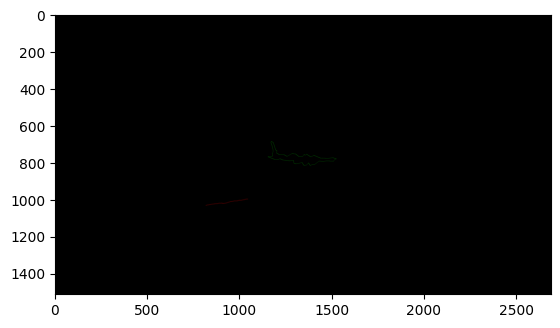

In [24]:
# 类别
num_classes = 3
def get_crack_mask_np_from_any_edge(num_classes, crack_mask_magma_pil_l_np,cls_num_edge_to_calculate_mid_axis_dict):
    for cls in range(1, num_classes+1):
        try:
            crack_edge_list = cls_num_edge_to_calculate_mid_axis_dict[cls]


            for crack_edge in crack_edge_list:
                # print(type(crack_edge))
                crack_edge = crack_edge.astype(int)
                # crack_mask_magma_pil_l_np中，在crack_edge一系列点的位置坐标处，设置为255
                crack_mask_magma_pil_l_np[crack_edge[:, 0], crack_edge[:, 1]] = cls
        
        except:
            print(f"No crack edge found for class={cls} in img_name={img_name}")
            continue
    return crack_mask_magma_pil_l_np

crack_mask_magma_pil_l_np = get_crack_mask_np_from_any_edge(num_classes, crack_mask_magma_pil_l_np,cls_num_edge_to_calculate_mid_axis_dict)
crack_mask_pil = colored_mask(crack_mask_magma_pil_l_np)
print('crack_mask_pil', crack_mask_pil.mode)
plt.imshow(crack_mask_pil)
plt.show()


In [28]:
cls_num_edge_pair_dict[1]

[array([[1000.77603912, 1031.22396088,  998.44792177, 1030.55207823],
        [1000.45012189, 1032.09975622,  998.        , 1031.55675908],
        [1001.43086709, 1029.13826581,  999.48588233, 1028.51411767],
        [1003.61693424, 1023.38306576, 1000.        , 1022.52618263],
        [1003.        , 1024.15160588, 1000.        , 1023.69678824],
        [1003.        , 1025.18594734, 1000.        , 1024.62810531],
        [1002.84320776, 1026.15679224, 1000.        , 1025.62810531],
        [1002.45012189, 1027.09975622, 1000.        , 1026.55675908],
        [1004.        , 1020.28659766, 1001.44551248, 1019.55448752],
        [1004.        , 1021.30277564, 1001.        , 1020.39444872],
        [1004.        , 1022.28659766, 1000.66826872, 1021.33173128],
        [1005.71206281, 1013.28793719, 1002.28793719, 1012.71206281],
        [1005.        , 1014.15160588, 1002.        , 1013.69678824],
        [1005.        , 1015.1181013 , 1002.        , 1014.76379741],
        [1004.880745

In [9]:
# 类别
import cv2
num_classes = 3
def get_crack_mask_np_from_pair_edge(num_classes, crack_mask_magma_pil_l_np, cls_num_edge_pair_dict):
    for cls in range(1, num_classes+1):
        try:
            crack_edge_list = cls_num_edge_pair_dict[cls]
            # print(crack_edge_list)

            for crack_edge in crack_edge_list:
                # print(type(crack_edge))
                crack_edge = crack_edge.astype(int)
                # crack_mask_magma_pil_l_np中，在crack_edge一系列点的位置坐标处，设置为255
                crack_mask_magma_pil_l_np[crack_edge[:, 0], crack_edge[:, 1]] = cls
                crack_mask_magma_pil_l_np[crack_edge[:, 2], crack_edge[:, 3]] = cls
        
        except:
            print(f"No crack edge found for class={cls} in img_name={img_name}")
            continue
    return crack_mask_magma_pil_l_np

crack_mask_magma_pil_l_np = get_crack_mask_np_from_pair_edge(num_classes, crack_mask_magma_pil_l_np, cls_num_edge_pair_dict)
crack_mask_pil = colored_mask(crack_mask_magma_pil_l_np)
print('crack_mask_magma_pil_l_np', crack_mask_magma_pil_l_np.shape)

# 在crack_mask_pil增加点
# crack_mask_pil = crack_mask_pil.convert('RGBA')
# for pt in crack_mask_magma_pil_l_np[:10]:
    
#     crack_mask_pil.putpixel((100, 100), (255, 0, 0, 255))
#     crack_mask_pil.putpixel((200, 200), (0, 255, 0, 255))
print('crack_mask_pil', crack_mask_pil.mode)
# plt.figure(figsize=(10, 10))
# plt.imshow(crack_mask_pil)
# plt.show()
# cv2.imshow(np.array(crack_mask_pil))
cv2.imshow('crack_mask_pil', np.array(crack_mask_pil.convert('RGB'))[:, :, ::-1])
cv2.waitKey(0)
cv2.destroyAllWindows()

No crack edge found for class=3 in img_name=0032
crack_mask_magma_pil_l_np (1512, 2688)
crack_mask_pil P


In [16]:
import numpy as np

a = np.array([[1, 3], [1, 4], [6, 7]])
b = np.array([[6, 7], [1, 3], [1, 4]])
# b = np.array([[1, 3], [1, 4], [6, 7]])
# 逐行查找索引
c = np.array([np.where((a == row).all(axis=1))[0][0] for row in b])

print("结果 c =", c)  # 输出: [2 0 1]

结果 c = [2 0 1]


In [14]:
a[:,0]

array([1, 1, 6])

## 2d points计算和展示

In [29]:
# img_name = '0001'
import cv2
import cv2.aruco as aruco

def distance_for_edge_pair(edge_pair):
    dist = (edge_pair[:,1]-edge_pair[:,3])**2 + (edge_pair[:,0]-edge_pair[:,2])**2
    return np.sqrt(dist)

def distance_for_2d_point(point_pair, start_at = 0):
    dist = (point_pair[start_at][0]-point_pair[start_at+1][0])**2 + (point_pair[start_at][1]-point_pair[start_at+1][1])**2
    return np.sqrt(dist)

img_name = '0032'
colmap_dir = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/datasets/dalian_xinghaiwandaqiao_video_input_rgb'
render_mesh_dir = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/output/dalian_xinghaiwandaqiao_rgb'
save_output_mesh_ray_dir = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/output/dalian_xinghaiwandaqiao_rgb/based_on_2d_npy_file_edge'
os.makedirs(save_output_mesh_ray_dir, exist_ok=True)
org_img_dir = f'/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/datasets/dalian_xinghaiwandaqiao_video_input_rgb/outputs/labelme_outputs/JPEGImages'



frame = cv2.imread(os.path.join(org_img_dir, img_name+'.jpg'))
#调整图片大小
# frame=cv2.resize(frame,None,fx=0.2,fy=0.2,interpolation=cv2.INTER_CUBIC)
frame=cv2.resize(frame,None,fx=1,fy=1,interpolation=cv2.INTER_CUBIC)
#灰度话
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#设置预定义的字典
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
#使用默认值初始化检测器参数
parameters =  aruco.DetectorParameters()
#使用aruco.detectMarkers()函数可以检测到marker，返回ID和标志板的4个角点坐标
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray,aruco_dict,parameters=parameters)
print("corners:",corners, corners[0].shape)
print('distance_for_2d_point:', [distance_for_2d_point(corners[0][0],start_at) for start_at in range((corners[0][0].shape[0]-1))])
mmp2dp = 132.0 / distance_for_2d_point(corners[0][0])
print("mmp2dp:", mmp2dp, 'mm/2dp')


edge_pair_npy_dir = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/output/dalian_xinghaiwandaqiao_rgb/img_point_width/edge_skel_edge_pair/cls_num_edge_pair_dict_0032.npy'

edge_pair_npy = np.load(edge_pair_npy_dir, allow_pickle=True).item()

edge_pair_npy_cls_1 = edge_pair_npy[1]

edge_pair_npy_cls_1_ls = []
for i in range(len(edge_pair_npy_cls_1)):
    edge_pair_npy_cls_1_ls.append(edge_pair_npy_cls_1[i])
    
edge_pair_npy_cls_1_ls_np = np.array(edge_pair_npy_cls_1_ls)
print(edge_pair_npy_cls_1_ls_np.shape)



edge_pair_npy_cls_1_ls_np_dist = [distance_for_edge_pair(distance) for distance in edge_pair_npy_cls_1_ls_np]
for i in edge_pair_npy_cls_1_ls_np_dist:
    print('pixel distance:', np.max(i), 'pixels')
    print('2d real distance:', np.max(i) * mmp2dp,'mm')

corners: (array([[[ 726., 1205.],
        [ 722., 1324.],
        [ 602., 1324.],
        [ 607., 1205.]]], dtype=float32),) (1, 4, 2)
distance_for_2d_point: [119.06720791217035, 120.0, 119.10499569707393]
mmp2dp: 1.1086175808990961 mm/2dp
(1, 105, 4)
pixel distance: 3.8150777604110555 pixels
2d real distance: 4.229462277688846 mm


256
[(0, 0, 4), (1, 0, 5), (2, 0, 6), (3, 0, 8), (4, 0, 9)]


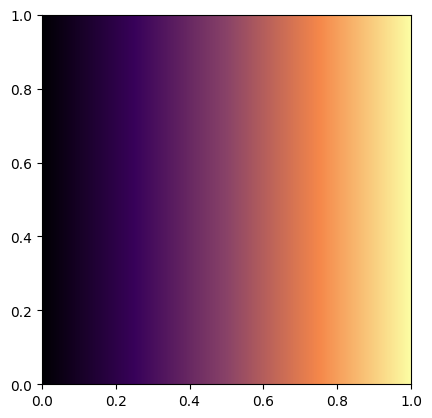

'\n示例输出:\n[(0, 0, 4), (13, 0, 46), (28, 1, 91), (56, 23, 113), (96, 53, 104)]\n'

In [37]:
def get_magma_color(t):
    """输入0-1的数值，返回对应的magma颜色（0-255的整型RGB元组）"""
    # 定义magma关键点的归一化RGB值（来自Matplotlib数据源）
    colors = [
        [0.001462, 0.000466, 0.013866],
        [0.219677, 0.004925, 0.351534],
        [0.538516, 0.261961, 0.406294],
        [0.961152, 0.529473, 0.288488],
        [0.988362, 0.998364, 0.644924]
    ]
    # 分段线性插值区间
    positions = [0.0, 0.25, 0.5, 0.75, 1.0]
    
    # 确定t所在的区间
    for i in range(len(positions)-1):
        if t >= positions[i] and t <= positions[i+1]:
            # 计算插值比例
            delta = (t - positions[i]) / (positions[i+1] - positions[i])
            # 对RGB三个通道分别插值
            r = colors[i][0] + (colors[i+1][0] - colors[i][0]) * delta
            g = colors[i][1] + (colors[i+1][1] - colors[i][1]) * delta
            b = colors[i][2] + (colors[i+1][2] - colors[i][2]) * delta
            # 转换为0-255的整数
            return (
                int(round(r * 255)),
                int(round(g * 255)),
                int(round(b * 255))
            )
    return (0, 0, 0)  # 默认返回黑色

def generate_magma_colormap(num=256):
    """生成包含num个颜色的magma配色列表"""
    colormap = []
    for i in range(num):
        t = i / (num - 1)  # 均匀采样0-1的范围
        colormap.append(get_magma_color(t))
    return colormap

# 示例：生成256级的magma配色
magma_colors = generate_magma_colormap()
print(len(magma_colors))
print(magma_colors[:5])  # 输出前5个颜色值
# 显示magma_colors的图像
import matplotlib.pyplot as plt
plt.imshow([magma_colors[:]], extent=[0, 1, 0, 1])
plt.show()
"""
示例输出:
[(0, 0, 4), (13, 0, 46), (28, 1, 91), (56, 23, 113), (96, 53, 104)]
"""

## 3d points计算和展示

In [1]:
import open3d
import numpy as np
import os
import cv2


def get_magma_color(t):
    """输入0-1的数值，返回对应的magma颜色（0-255的整型RGB元组）"""
    # 定义magma关键点的归一化RGB值（来自Matplotlib数据源）
    colors = [
        [0.001462, 0.000466, 0.013866],
        [0.219677, 0.004925, 0.351534],
        [0.538516, 0.261961, 0.406294],
        [0.961152, 0.529473, 0.288488],
        [0.988362, 0.998364, 0.644924]
    ]
    # 分段线性插值区间
    positions = [0.0, 0.25, 0.5, 0.75, 1.0]
    
    # 确定t所在的区间
    for i in range(len(positions)-1):
        if t >= positions[i] and t <= positions[i+1]:
            # 计算插值比例
            delta = (t - positions[i]) / (positions[i+1] - positions[i])
            # 对RGB三个通道分别插值
            r = colors[i][0] + (colors[i+1][0] - colors[i][0]) * delta
            g = colors[i][1] + (colors[i+1][1] - colors[i][1]) * delta
            b = colors[i][2] + (colors[i+1][2] - colors[i][2]) * delta
            # 转换为0-255的整数
            return (
                int(round(r * 255)),
                int(round(g * 255)),
                int(round(b * 255))
            )
    return (0, 0, 0)  # 默认返回黑色

def generate_magma_colormap(num=256):
    """生成包含num个颜色的magma配色列表"""
    colormap = []
    for i in range(num):
        t = i / (num - 1)  # 均匀采样0-1的范围
        colormap.append(get_magma_color(t))
    return colormap

# 示例：生成256级的magma配色
magma_colors = generate_magma_colormap()


hit_points_dir = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/output/dalian_xinghaiwandaqiao_rgb/based_on_2d_npy_file_edge/hit_points_from_2d_npy_with_markers/0032.npy'
load = np.load(hit_points_dir, allow_pickle=True)
hit_points = load.item()
# print(hit_points)
# print('len(hit_points):', len(hit_points))

all_points = hit_points['all_points_list']
all_colors = hit_points['all_colors_list']
only_colors = hit_points['each_cls_colors']

only_pair_points = hit_points['each_cls_num_points']
# print(only_pair_points)
print(np.array(only_pair_points[1][0]).shape)
print(np.array(only_pair_points[1][1]).shape)
demo_one = np.vstack((np.array(only_pair_points[1][0]), np.array(only_pair_points[1][1])))
print(demo_one.shape)

cls_dist_each_3d_point_dict = hit_points['cls_dist_each_3d_point_dict']
cls_center_points_dict = hit_points['cls_center_points_dict']
mmp3dp = hit_points['mmp3dp']

print('len(all_points):', len(all_points))
print('len(all_colors):', len(all_colors))
print('len(only_pair_points):', len(only_pair_points),  np.array(only_pair_points[1]).shape,  np.array(only_pair_points[2]).shape)
print('len(only_colors):', len(only_colors), np.array(only_colors[1]).shape,  np.array(only_colors[2]).shape)
print('cls_dist_each_3d_point_dict:', len(cls_dist_each_3d_point_dict),len(cls_dist_each_3d_point_dict[1][0]))
print('cls_center_points_dict:', len(cls_center_points_dict), len(cls_center_points_dict[1][0]))
#################################### 按照距离排序颜色magma #############################################


def magma_color_norm(each_distance, magma_colors):
    each_distance = np.array(each_distance)
    each_distance_max = np.max(each_distance)
    each_distance_max_index = np.argmax(each_distance)
    each_distance_min = np.min(each_distance)
    # 将each_distance从达到小分为256份，并计算每份按照大小顺序在each_distance的位置id
    each_distance_sort_index = np.argsort(each_distance)
    each_distance_sort_index_norm = (each_distance_sort_index - each_distance_min) / (each_distance_max - each_distance_min) * 255
    each_distance_sort_index_norm = each_distance_sort_index_norm.astype(np.uint8)
    print(each_distance_sort_index_norm, len(each_distance_sort_index_norm))
    magma_color_each_distance = []
    for i in each_distance_sort_index_norm:
        magma_color_each_distance.append(magma_colors[i])
    magma_color_each_distance_np = np.array(magma_color_each_distance)
    print(magma_color_each_distance_np.shape)

    print('each_distance:', each_distance.shape)
    max_dist_3d_point = np.max(np.array(cls_dist_each_3d_point_dict[1][0]))
    print('max_dist_3d_point:', max_dist_3d_point * mmp3dp)
    return magma_color_each_distance_np, each_distance_max, each_distance_max_index


cls_center_points = np.array(cls_center_points_dict[1][0])
print(cls_center_points.shape)
# demo_one_color = magma_color_norm(demo_one, magma_colors)
cls_center_points_color, each_distance_max, each_distance_max_index = magma_color_norm(np.array(cls_dist_each_3d_point_dict[1][0]), magma_colors)
print(len(cls_center_points_color), cls_center_points_color)
cls_center_points_color[each_distance_max_index] = [255, 0, 0]
print(each_distance_max, each_distance_max_index)
######################################################################################
# print(all_points, type(all_points))
# open3d显示all_points
import open3d
import numpy as np
# all_points = np.array(all_points)
# print(all_points.shape)
# print(all_points)
# print('np.vstack((demo_one, np.array(cls_center_points_dict[1][0]))).shape[0]:', np.vstack((demo_one, np.array(cls_center_points_dict[1][0]))).shape[0])
# print('np.vstack((demo_one, np.array(cls_center_points_dict[1][0]))).shape:', np.vstack((demo_one, np.array(cls_center_points_dict[1][0]))).shape)
# print(np.array(cls_center_points_dict[1][0]).shape)
# print(demo_one)
print(demo_one.shape)
n = 100
# 设置黑色背景
from open3d.visualization import Visualizer

vis = open3d.visualization.Visualizer()
vis.create_window(visible=True)
all_points_pcd = open3d.geometry.PointCloud()

print((np.vstack(([[128, 0, 0]]*demo_one.shape[0], cls_center_points_color))).shape)
print((np.vstack((demo_one, cls_center_points))).shape)


# opt = vis.get_render_option()
# opt.background_color = np.array([0, 0, 0])

all_points_pcd.points = open3d.utility.Vector3dVector(np.vstack((demo_one, cls_center_points)))
# all_points_pcd.points = open3d.utility.Vector3dVector(demo_one)
# open3d.visualization.draw_geometries([np.array(all_points)])
all_points_pcd.colors = open3d.utility.Vector3dVector(np.vstack(([[0, 128, 0]]*demo_one.shape[0], cls_center_points_color.tolist())))
# all_points_pcd.colors = open3d.utility.Vector3dVector(np.vstack(([[128, 0, 0]]*demo_one.shape[0], [[0, 128, 0]]*np.array(cls_center_points_dict[1][0]))))
# all_points_pcd.colors = open3d.utility.Vector3dVector(np.array([[1, 0, 0]]*demo_one.shape[0]))

vis.add_geometry(all_points_pcd)


opt = vis.get_render_option()
opt.background_color = np.asarray([0, 0, 0])
vis.run()
# vis.wait_for_events()
vis.destroy_window()

# open3d.visualization.draw_geometries([all_points_pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
(105, 3)
(105, 3)
(210, 3)
len(all_points): 1086
len(all_colors): 1086
len(only_pair_points): 2 (2, 105, 3) (2, 436, 3)
len(only_colors): 2 (2, 105) (2, 436)
cls_dist_each_3d_point_dict: 2 105
cls_center_points_dict: 2 105
(105, 3)
[136 165  73 104  10 236  40  70  76 230   7  71  39 200 233  41 105 235
 172 170 169 140  77  81  19 115  82 238 103 203  11 202  75  13 141 167
   6 102 198  38 134 135 231 168 199 234 232 137 201  43   9  74  42  12
 109  44 205 173 237 209 175 143  48  79 178 208 146 241 174  14 110  51
  50 112 147  16 243 180 176 145 240  80  49 142  47  72 139 108 107 138
 171  18 114 113 206  45  17 207  78 111 239 177 211 210  15] 105
(105, 3)
each_distance: (105,)
max_dist_3d_point: 4.942730299359887
105 [[152  76 100]
 [201 107  86]
 [ 68  11  92]
 [107  43  98]
 [  9   0  17]
 [250 219 137]
 [ 35 

In [15]:
a = [2,2]
a*2

[2, 2, 2, 2]

In [32]:
crack_mask_magma_pil_l_np.shape

(1512, 2688)

In [33]:
# 读取npy文件
import numpy as np
import os

npy_dir_file = '/home/ubunto/Project/konglx/pcd/2dgs/2d-gaussian-splatting-main/output/dalian_xinghaiwandaqiao_rgb/based_on_2d_npy_file_edge/hit_points_from_2d_npy_with_markers/0032.npy'
file = np.load(npy_dir_file, allow_pickle=True)
file = file.item()

print(file.keys())

print(file['each_cls_num_points'])
print(file['each_cls_colors'])

# 提取骨架点

dict_keys(['all_points_list', 'all_colors_list', 'only_defects_cls_length', 'each_cls_num_points', 'each_cls_colors', 'mmp3dp'])
{1: [[array([1.33148131, 1.07125232, 4.37878458]), array([1.33281331, 1.07121281, 4.37693562])]], 2: [[array([1.33148131, 1.07125232, 4.37878458]), array([1.33281331, 1.07121281, 4.37693562])]]}
{1: [[]], 2: [[]]}
